# What are Generative Adversarial Networks and how they work?
GANs are generative models which are used to generate fake things such as images, audio and videos. GANs contain two neural networks the Generator and the Discriminator. Generator generates new random data patterns whereas the discriminator checks classifies the data pattern generated by discriminator as real (belonging to the original training set) or fake.

Why the name adversarial came, is there any conflict in between any two things here? Yes, the name adversarial came because the two networks generator and discriminator works in a conflicting or opposite manner. Main aim of generator is to fool discriminator.

## How GANs generate fake faces?
The following steps are followed by a GAN used for face generation :

- Generator takes an array of random numbers having size equal to seed size and generates an image.
- The generated images with equal number of real face images (which are used for training) are passed to the    discriminator for their classification as real or fake.
- Discriminator now passes its result as a loss again to the generator to make itself more accurate in producing fake images.
- This process keeps iterating for a desired number of times, hence generator keeps on improving its output so as to fool the discriminator

![gans.png](assets/gans.png)

### Importing dependencies

In [1]:
import cv2
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import tqdm
!pip install git+https://github.com/tensorflow/docs
import glob
import imageio
import PIL
from IPython import display

/bin/bash: /home/labeeb/miniconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-_ybihf3d
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-_ybihf3d
  Resolved https://github.com/tensorflow/docs to commit f863411235c24209073d5138ee2e434c843325ff
  Preparing metadata (setup.py) ... done


In [56]:

SIZE = 256
_img = []
path = './without_mask'
files = os.listdir(path)
for i in tqdm.tqdm(files):    
      img = cv2.imread(path + '/'+i,1)
      # open cv reads images in BGR format so we have to convert it to RGB
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      #resizing image
      img = cv2.resize(img, (SIZE, SIZE))
      img = (img - 127.5) / 127.5
      imh = img.astype(float)
      _img.append(keras.preprocessing.image.img_to_array(img))

100%|███████████████████████████████████████████████████████████████████████████████| 9896/9896 [07:01<00:00, 23.48it/s]


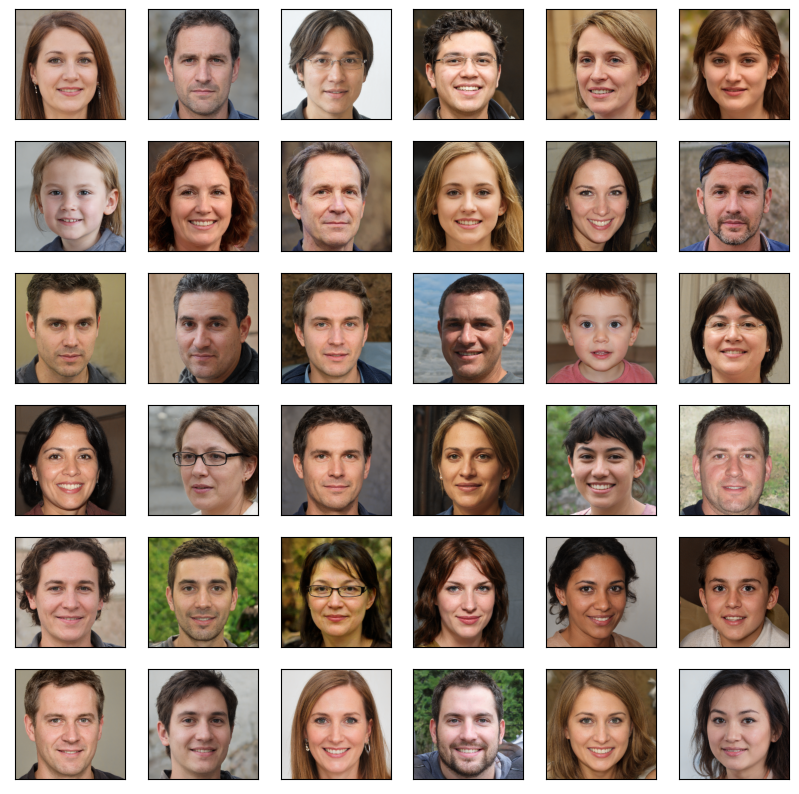

In [58]:
def plot_images(sqr = 5):
    plt.figure(figsize = (10,10))
    plt.title("Real Images",fontsize = 35)
    for i in range(sqr * sqr):
        plt.subplot(sqr,sqr,i+1)
        plt.imshow(_img[i]*0.5 + 0.5 )
        plt.xticks([])
        plt.yticks([])

# to plot images
plot_images(6)

#### Setting up tensorflow environment according to model training

In [2]:
os.environ['TF_GPU_ALLOCATOR']='cuda_malloc_async' 
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.set_visible_devices(physical_devices[2:3], 'GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], False)

Latent dim defines the size of the input vector to generator

In [1]:
latent_dim = 100

#### Defining the generator

In [2]:
def Generator():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(256*256*3, use_bias=False, input_shape=(latent_dim,)))
    model.add(tf.keras.layers.Reshape((256,256,3)))
    # downsampling
    model.add(tf.keras.layers.Conv2D(256,4, strides=1, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.Conv2D(256,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2D(128,4, strides=1, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.Conv2D(128,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(256,4, strides=1, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.Conv2D(256,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2DTranspose(512, 4, strides=1,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.Conv2D(512,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    
    model.add(tf.keras.layers.LeakyReLU())
    #upsampling
    model.add(tf.keras.layers.Conv2DTranspose(512, 4, strides=1,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.Conv2DTranspose(512, 4, strides=2,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2DTranspose(256, 4, strides=1,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.Conv2DTranspose(256, 4, strides=2,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    
    model.add(tf.keras.layers.Conv2DTranspose(128, 4, strides=2,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.Conv2DTranspose(128, 4, strides=1,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2DTranspose(256, 4, strides=2,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.Conv2DTranspose(256, 4, strides=1,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2DTranspose(128, 4, strides=1,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2DTranspose(64, 4, strides=1,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2DTranspose(32, 4, strides=1,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2DTranspose(3,4,strides = 1, padding = 'same',activation = 'tanh'))
    
    

    return model

In [4]:
with tf.device('/gpu:2') :
    generator = Generator()
    generator.summary()

2022-10-14 13:31:19.493612: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-14 13:31:20.024112: I tensorflow/core/common_runtime/gpu/gpu_process_state.cc:222] Using CUDA malloc Async allocator for GPU: 2
2022-10-14 13:31:20.025267: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 37924 MB memory:  -> device: 2, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 196608)            19660800  
                                                                 
 reshape (Reshape)           (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 256)     12288     
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 256)     1048576   
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 256)    1024      
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 128)     524288    
                                                        

#### Defining the Discriminator

In [5]:
def Discriminator():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Input((SIZE, SIZE, 3)))
    model.add(tf.keras.layers.Conv2D(256,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(256,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(128,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(256,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(256,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(512,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1,activation = 'sigmoid'))
    return model
  


In [6]:
SIZE=256
with tf.device('/gpu:2') :
    discriminator = Discriminator()
    discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 128, 128, 256)     12288     
                                                                 
 batch_normalization_10 (Bat  (None, 128, 128, 256)    1024      
 chNormalization)                                                
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 128, 128, 256)     0         
                                                                 
 conv2d_8 (Conv2D)           (None, 64, 64, 256)       1048576   
                                                                 
 batch_normalization_11 (Bat  (None, 64, 64, 256)      1024      
 chNormalization)                                                
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 64, 64, 256)      

### Visualizing the input which is fed to generator

2022-10-14 13:31:26.603835: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-10-14 13:31:27.101689: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


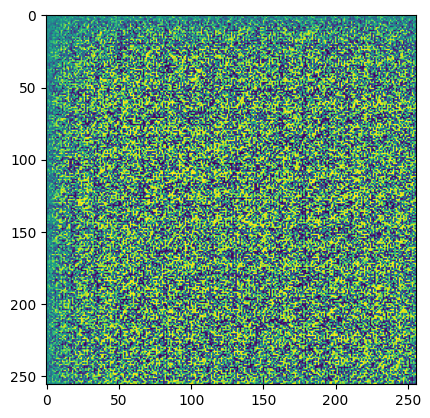

In [7]:
noise = np.random.normal(-1,1,(1,100))
#with strategy.scope() :
img = generator(noise)
plt.imshow(img[0,:,:,0])
plt.show()

### Defining the optimizer and loss

In [8]:
with tf.device('/gpu:2'):
    optimizer = tf.keras.optimizers.RMSprop(
            learning_rate=.0001,
            clipvalue=1.0,
            decay=1e-8
        )
    cross_entropy = tf.keras.losses.BinaryCrossentropy()

In [9]:
with tf.device('/gpu:2') :
    noise_dim = 100
    num_examples_to_generate = 16
    seed = tf.random.normal([num_examples_to_generate, noise_dim])

For checkpoints

In [21]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=optimizer,
                                 discriminator_optimizer=optimizer,
                                 generator=generator,
                                 discriminator=discriminator)
ckpt_manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=5)
with tf.device('/gpu:2') :
    if ckpt_manager.latest_checkpoint:
      checkpoint.restore(ckpt_manager.latest_checkpoint)
      print ('Latest checkpoint restored!!')

Latest checkpoint restored!!


#### Defining generator and discriminator loss

In [69]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output),fake_output)
def discriminator_loss(fake_output, real_output):
    #with strategy.scope() :
        fake_loss = cross_entropy(tf.zeros_like(fake_output),fake_output)
        real_loss = cross_entropy(tf.ones_like(real_output),real_output)
        return fake_loss+real_loss

In [70]:
@tf.function
def train_steps(images):
    with tf.device('/gpu:2'):
        noise = np.random.normal(0,1,(batch_size,latent_dim))
        with tf.GradientTape() as gen_tape , tf.GradientTape() as disc_tape:
            generated_images = generator(noise)
            fake_output = discriminator(generated_images)
            real_output = discriminator(images)
            
            gen_loss = generator_loss(fake_output)
            dis_loss = discriminator_loss(fake_output, real_output)


        gradient_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)    
        gradient_of_discriminator = disc_tape.gradient(dis_loss, discriminator.trainable_variables)

        optimizer.apply_gradients(zip(gradient_of_generator,generator.trainable_variables))
        optimizer.apply_gradients(zip(gradient_of_discriminator, discriminator.trainable_variables))

        loss = {'gen loss':gen_loss,
               'disc loss': dis_loss}
        return loss

Utility function to plot generated images

In [11]:
def plot_generated_images(square = 5, epochs = 0):
    
    
  plt.figure(figsize = (10,10))
  for i in range(square * square):
    if epochs != 0:    
        if(i == square //2):
            plt.title("Generated Image at Epoch:{}\n".format(epochs), fontsize = 32, color = 'black')
    plt.subplot(square, square, i+1)
    noise = np.random.normal(0,1,(1,latent_dim))
    img = generator(noise)
    plt.imshow(np.clip((img[0,...]+1)/2, 0, 1))
    
    plt.xticks([])
    plt.yticks([])
    plt.grid()

Utility function to generate images

In [98]:
def generate_and_save_images(model, epoch, test_input):
  img = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(img.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(np.clip((img[i,...]+1)/2, 0, 1))
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [96]:
import time
def train(epochs,dataset):
   with tf.device('/gpu:2') :
        for epoch in range(epochs):
            start = time.time()

            print("\nEpoch : {}".format(epoch + 1))
            for images in dataset:
                loss = train_steps(images)
                print(".",end="")


            #display.clear_output(wait=True)
            generate_and_save_images(generator,
                                 epoch + 1,
                                 seed)

            if (epoch + 1) % 2 == 0:
                    checkpoint.save(file_prefix = checkpoint_prefix)
            print(" Time:{}".format(np.round(time.time() - start),2)) 
            print("Generator Loss: {} Discriminator Loss: {}".format(loss['gen loss'],loss['disc loss']))

        #display.clear_output(wait=True)
        generate_and_save_images(generator,
                               epochs,
                               seed)

In [ ]:
batch_size = 32
dataset=tf.data.Dataset.from_tensor_slices(np.array(_img)).batch(batch_size)

In [ ]:
with tf.device('/gpu:2') :
    train(60,dataset)

In [ ]:
#checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

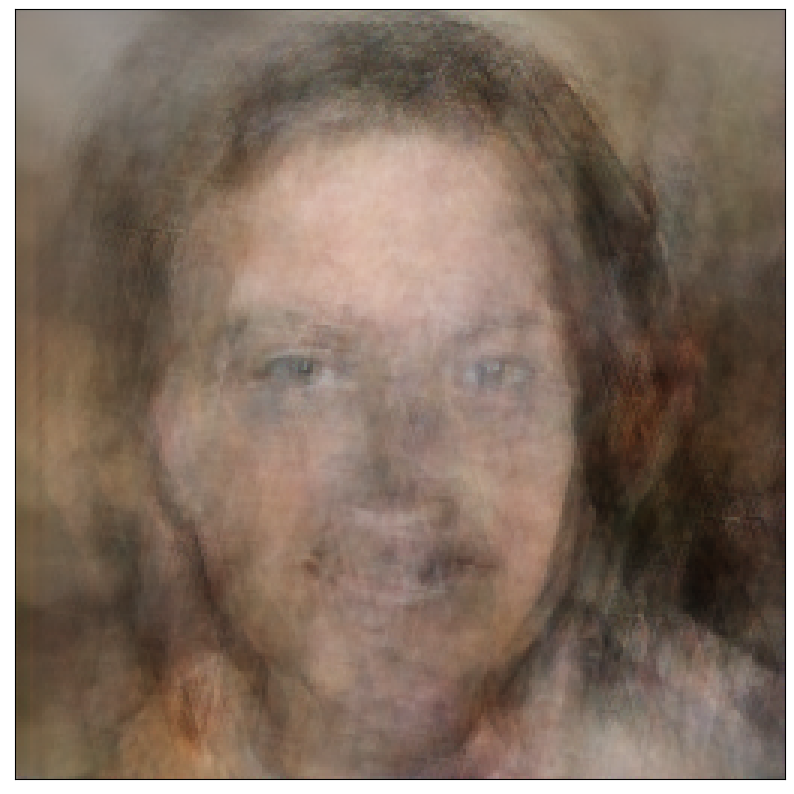

In [32]:
plot_generated_images(1)